In [1]:
# setting up paths
from sys import path, stdout
from os import environ

path.append("/home/leandrosantos/IC-AutoEncoder/")
path.append("/home/leandrosantos/IC-AutoEncoder/modules/")
path.append("/home/leandrosantos/IC-AutoEncoder/src/modules/")

environ["CUDA_VISIBLE_DEVICES"] = "3"

import tensorflow as tf
import random as rd

seed = 3344323
rd.seed(seed)
tf.random.set_seed(seed)

2023-10-21 23:23:01.258235: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam

from tensorflow.keras import Sequential
from modules.CustomLosses import L3SSIM

from modules.misc import ssim_metric
from modules.ImageMetrics.metrics import three_ssim, psnrb

import keras_tuner as kt

In [3]:
# Fetching datasets

from modules.DataMod import DataSet
import cupy

cifar, tiny, noised_dataset = DataSet(), DataSet(), DataSet()

cifar.load_rafael_cifar_10_noise_data()
tiny.load_rafael_tinyImagenet_64x64_noise_data()
print("Cifar and tiny loaded.")

noised_dataset.load_cifar_and_tiny(cifar, tiny)
noised_dataset.add_gaussian_noise(dist_normal = 0.3) # adds gaussian noise

print("Dataset created.")

cupy.get_default_memory_pool().free_all_blocks()
cupy.get_default_pinned_memory_pool().free_all_blocks()

del cifar, tiny

Cifar and tiny loaded.
Dataset created.


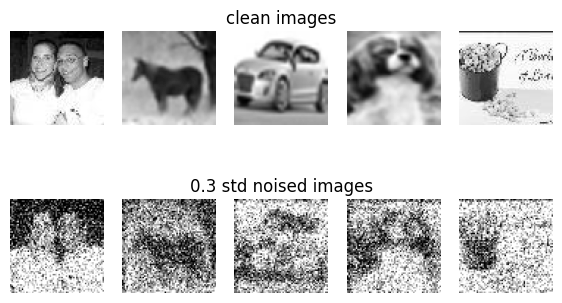

In [4]:
# seeing the noised datasets 

from matplotlib import pyplot as plt

plt.figure(figsize=(7, 4))
columns = 5
rows = 2

magic_number = [rd.randint(0, noised_dataset.x_train.shape[0]-1) for x in range(columns)]

plt.subplot(rows, columns, 3)
plt.title("clean images")
plt.subplot(rows, columns, 8)
plt.title("0.3 std noised images")

for idx in range(columns):
    plt.subplot(rows, columns, idx+1)
    plt.imshow(noised_dataset.y_train[magic_number[idx]], cmap="gray")
    plt.axis("off")
    plt.subplot(rows, columns, idx+columns+1)
    plt.imshow(noised_dataset.x_train[magic_number[idx]], cmap="gray")
    plt.axis("off")

In [5]:
# Defining model

from keras_tuner import HyperParameters

def tunning_model(hp : HyperParameters):
    
    model = Sequential(name="autoEncoder")
    
    ext_kernel_sz = 4
    int_kernel_sz = 3
    
    step = 16
    l1_filters = hp.Int('conv1_filters', min_value = 10, max_value = 60, step=step)
    l2_filters = hp.Int('conv2_filters', min_value=15, max_value=70, step=step)
    l3_filters = hp.Int('conv3_filters', min_value=20, max_value=90, step=step)
    l4_filters = hp.Int('conv4_filters', min_value=30, max_value=120, step=step)
    l5_filters = hp.Int('conv5_filters', min_value=40, max_value=150, step=step)
    l6_filters = hp.Int('conv6_filters', min_value=50, max_value=170, step=step)
    l7_filters = hp.Int('conv7_filters', min_value=60, max_value=190, step=step)
    l8_filters = hp.Int('conv8_filters', min_value=70, max_value=220, step=step)
    l9_filters = hp.Int('conv9_filters', min_value=80, max_value=250, step=step)
    l10_filters = hp.Int('conv10_filters', min_value=90, max_value=270, step=step)
    l11_filters = hp.Int('conv11_filters', min_value=100, max_value=300, step=step)
    l12_filters = hp.Int('conv12_filters', min_value=150, max_value=350, step=step)
    l13_filters = hp.Int('conv13_filters', min_value=200, max_value=450, step=step)
    
    model.add(Conv2D(input_shape=(64,64,1), filters =l1_filters , kernel_size = ext_kernel_sz, padding = 'same', activation = 'relu'))
    model.add(Conv2D(filters = l2_filters, kernel_size = ext_kernel_sz, padding = 'same', activation = 'relu'))
    model.add(MaxPooling2D())
    model.add(BatchNormalization())
    
    model.add(Conv2D(filters = l3_filters, kernel_size = int_kernel_sz, padding = 'same', activation = 'relu'))
    model.add(Conv2D(filters = l4_filters, kernel_size = int_kernel_sz, padding = 'same', activation = 'relu'))
    model.add(MaxPooling2D())

    model.add(Conv2D(filters = l5_filters, kernel_size = int_kernel_sz, padding = 'same', activation = 'relu'))
    model.add(Conv2D(filters = l6_filters, kernel_size = int_kernel_sz, padding = 'same', activation = 'relu'))
    model.add(MaxPooling2D())
    model.add(BatchNormalization())

    model.add(Conv2D(filters = l7_filters, kernel_size = int_kernel_sz, padding = 'same', activation = 'relu'))
    model.add(Conv2D(filters = l8_filters, kernel_size = int_kernel_sz, padding = 'same', activation = 'relu'))
    model.add(UpSampling2D())

    model.add(Conv2D(filters = l9_filters, kernel_size = int_kernel_sz, padding = 'same', activation = 'relu'))
    model.add(Conv2D(filters = l10_filters, kernel_size = int_kernel_sz, padding = 'same', activation = 'relu'))
    model.add(UpSampling2D())
    model.add(BatchNormalization())

    model.add(Conv2D(filters = l11_filters, kernel_size = int_kernel_sz, padding = 'same', activation = 'relu'))
    model.add(Conv2D(filters = l12_filters, kernel_size = int_kernel_sz, padding = 'same', activation = 'relu'))
    model.add(UpSampling2D())
    model.add(BatchNormalization())

    model.add(Conv2D(filters = l13_filters, kernel_size = ext_kernel_sz, padding = 'same', activation = 'relu'))
    model.add(Conv2D(filters = 1, kernel_size = ext_kernel_sz, padding = 'same', activation = 'relu'))

    # passo 2
    # kernel sizes
    # passo 3
    # ativações
    # passo 4
    # weight_decay = hp.Float('weight_decay', min_value=1e-6, max_value=1e-3, sampling="log", step=10)
    # learning_rate = hp.Float('learning_rate', min_value=5e-4, max_value=1e-2, sampling="log", step=10)
    # passo 5
    # batch_size e num_epochs
    # passo 6
    # inicialização dos pesos
                     
    model.compile(optimizer = Adam(), loss = L3SSIM(), metrics=[ssim_metric])

    return model

In [6]:
tuner = kt.BayesianOptimization(hypermodel=tunning_model, objective = kt.Objective('ssim_metric', 'max'),
                          max_trials=30, seed = seed, max_retries_per_trial = 1, max_consecutive_failed_trials = 5,
                          directory="logs", project_name="num_filters_tunning", overwrite=False)

tuner.search(noised_dataset.x_train, noised_dataset.y_train, epochs = 10, batch_size = 32, validation_data=(noised_dataset.x_test, noised_dataset.y_test))

INFO:tensorflow:Reloading Tuner from logs/num_filters_tunning/tuner0.json
INFO:tensorflow:Oracle triggered exit


In [7]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [9]:
# Build the model with the optimal hyperparameters and train it on the data for 20 epochs

from Trainer import NetTrainer

trainer = NetTrainer(tunning_model, noised_dataset, hyperparams=best_hps, epochs=100, batch_size=20, tracking_metric="val_ssim_metric", logs_path="logs/weights_checkpoints/")
trainer.start_training()

TypeError: NetTrainer.__get_last_epoch() missing 1 required positional argument: 'path'

In [ ]:
val_ssim_per_epoch = trainer.history.history['val_ssim_metric']
print(val_ssim_per_epoch)

# train x test accuracy

# model loss x ssim plot

# all 30 plots num_params x value got